<a href="https://colab.research.google.com/github/susmitmishra125/aerial-cactus-identification/blob/main/Aerial_cactus_indentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 from google.colab import files

In [ ]:
files.upload()

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [6]:
 ! chmod 600 ~/.kaggle/kaggle.json
#  !kaggle datasets list

In [7]:
!mkdir -p data
!kaggle competitions download -c aerial-cactus-identification -p data

  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 41.7MB/s]
 57% 11.0M/19.2M [00:00<00:00, 57.7MB/s]
100% 19.2M/19.2M [00:00<00:00, 76.2MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 168MB/s]
100% 4.20M/4.20M [00:00<00:00, 37.6MB/s]



In [ ]:
!unzip data/train.zip -d data
!unzip data/test.zip -d data

In [39]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

In [10]:
train_csv = pd.read_csv('data/train.csv')
print(train_csv.describe())
print(train_csv.head())

         has_cactus
count  17500.000000
mean       0.750629
std        0.432662
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1


In [11]:
filenames = ['data/train/' + fname for fname in train_csv['id'].tolist()]
labels = train_csv['has_cactus'].tolist()

train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames,
                                                                            labels,
                                                                            train_size=0.9,
                                                                            random_state=420)

num_train = len(train_filenames)
num_val = len(val_filenames)

In [16]:
IMAGE_SIZE = 224


def _parse_fn(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
  image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
  return image_resized, label

In [17]:
BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels))).map(_parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE)


val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels))).map(_parse_fn).batch(BATCH_SIZE)

In [18]:
# Base model with MobileNetV2
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [20]:
learning_rate = 0.001

model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
num_epochs = 30
steps_per_epoch = round(num_train)//BATCH_SIZE
val_steps = 20

In [22]:
history = model.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps)

Epoch 1/30
492/492 [==============================] - 45s 57ms/step - loss: 0.2992 - accuracy: 0.8960 - val_loss: 0.0775 - val_accuracy: 0.9750
Epoch 2/30
492/492 [==============================] - 34s 69ms/step - loss: 0.0663 - accuracy: 0.9734 - val_loss: 0.0748 - val_accuracy: 0.9703
Epoch 3/30
492/492 [==============================] - 34s 69ms/step - loss: 0.0524 - accuracy: 0.9802 - val_loss: 0.0572 - val_accuracy: 0.9812
Epoch 4/30
492/492 [==============================] - 34s 69ms/step - loss: 0.0387 - accuracy: 0.9837 - val_loss: 0.0574 - val_accuracy: 0.9797
Epoch 5/30
492/492 [==============================] - 34s 68ms/step - loss: 0.0389 - accuracy: 0.9848 - val_loss: 0.0607 - val_accuracy: 0.9750
Epoch 6/30
492/492 [==============================] - 34s 69ms/step - loss: 0.0298 - accuracy: 0.9887 - val_loss: 0.0596 - val_accuracy: 0.9812
Epoch 7/30
492/492 [==============================] - 34s 69ms/step - loss: 0.0271 - accuracy: 0.9897 - val_loss: 0.0557 - val_accuracy:

In [23]:
model.save_weights('weights_epoch_30.h5')

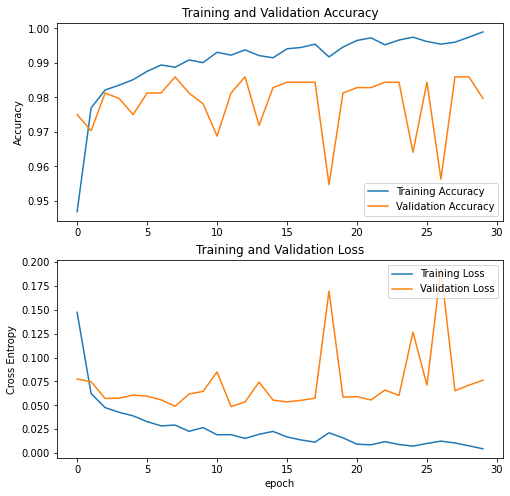

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
base_model.trainable = True

# Refreeze layers until the layers we want to fine-tune
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [27]:
fine_tune_epochs = 30
total_epochs =  num_epochs + fine_tune_epochs

history_fine = model.fit(train_data.repeat(), 
                         steps_per_epoch = steps_per_epoch,
                         epochs=total_epochs, 
                         initial_epoch = num_epochs,
                         validation_data=val_data.repeat(), 
                         validation_steps=val_steps)

Epoch 31/60
492/492 [==============================] - 44s 69ms/step - loss: 0.4396 - accuracy: 0.9412 - val_loss: 1.9332 - val_accuracy: 0.7937
Epoch 32/60
492/492 [==============================] - 40s 81ms/step - loss: 0.0950 - accuracy: 0.9848 - val_loss: 1.0760 - val_accuracy: 0.8828
Epoch 33/60
492/492 [==============================] - 40s 82ms/step - loss: 0.0529 - accuracy: 0.9923 - val_loss: 0.2721 - val_accuracy: 0.9703
Epoch 34/60
492/492 [==============================] - 40s 81ms/step - loss: 0.0383 - accuracy: 0.9942 - val_loss: 0.3004 - val_accuracy: 0.9703
Epoch 35/60
492/492 [==============================] - 40s 82ms/step - loss: 0.0497 - accuracy: 0.9940 - val_loss: 0.0896 - val_accuracy: 0.9891
Epoch 36/60
492/492 [==============================] - 40s 82ms/step - loss: 0.0208 - accuracy: 0.9951 - val_loss: 0.0570 - val_accuracy: 0.9937
Epoch 37/60
492/492 [==============================] - 40s 81ms/step - loss: 0.0484 - accuracy: 0.9941 - val_loss: 0.1073 - val_ac

In [28]:
model.save_weights('weights_epoch_50_finetuned.h5')

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

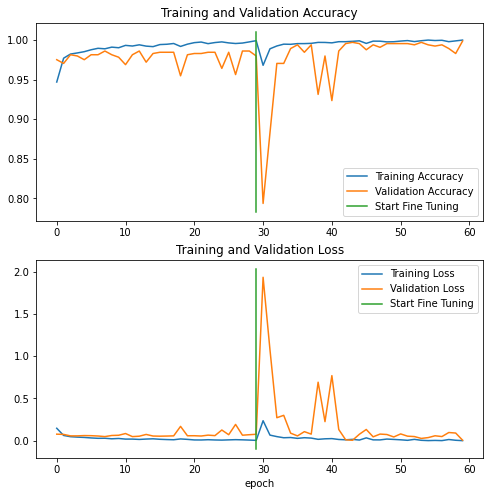

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([num_epochs-1,num_epochs-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([num_epochs-1,num_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
def _parse_fn_test(filename):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
  image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
  return image_resized

In [32]:
test_filenames=['data/test/'+  fname for fname in os.listdir('data/test')]
test_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(test_filenames))
)
test_data=(test_data.map(_parse_fn_test).batch((BATCH_SIZE)))
pred=model.predict(test_data)

In [33]:
df_sample=pd.read_csv('data/sample_submission.csv')
df_sample.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [ ]:
df=pd.DataFrame(test_filenames,columns=['id'])
df['id']=df['id'].apply(lambda x : x.split('/')[-1])
df['has_cactus']=pred
df.to_csv('submission.csv',index=False)
!kaggle competitions submit aerial-cactus-identification -f submission.csv -m "My submission"

In [ ]:
# from google.colab import files
# files.download('submission.csv')

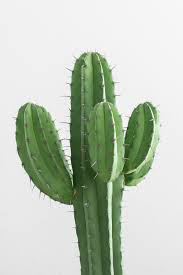

In [67]:
PIL.Image.open('index.jpg')# image of a cactus 

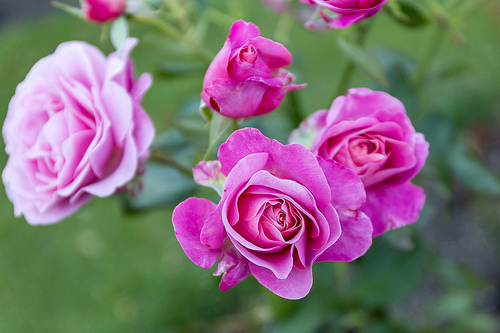

In [68]:
PIL.Image.open('index (1).jpg')#image of a non cactus

In [69]:
example_data=tf.data.Dataset.from_tensor_slices(tf.constant(['index.jpg','index (1).jpg']))
example_data=(example_data.map(_parse_fn_test).batch((BATCH_SIZE)))
pred=model.predict(example_data)

In [70]:
print("The probability that the first image is a cactus is",pred[0][0])
print("The probability that the first image is a cactus is",pred[1][0])

The probability that the first image is a cactus is 1.0
The probability that the first image is a cactus is 5.871593e-06
